In [1]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data
from models.EdgeNet import EdgeNet, NodeNet, EdgeNODE, W1W2Net, EdgeODENet
from torch.optim import Adam

In [2]:
# run only if new data is desired
ode_dim = 2
n_data = 4
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,100)

dataset = []
for i in range(0,len(x_train)):
    dataset.append(to_pyg_data(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset,batch_size=32,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    dataset.append(to_pyg_data(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [3]:
model = EdgeODENet(n_data, ode_dim, ode_dim ** 2)
optimizer = Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
reg = torch.nn.L1Loss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(1000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out.flatten(), data.y)
        # loss = loss + 0.0001*reg(out.flatten(),0*out.flatten())
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = criterion(out.flatten(), data.y)
            # print(loss.item())
            test_loss.append(loss)

torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([128, 1])
torch.Size([128, 9])
torch.Size([128, 4])


RuntimeError: shape '[256, 2, 2]' is invalid for input of size 256

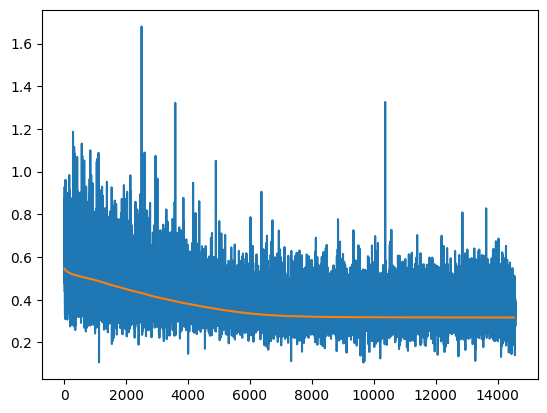

0.022
0.001
0.6425555555555555
0.4471111111111111


In [ ]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(y_val[i])
    Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)